In [2]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
#load dataset
dataset = pd.read_csv(r'C:\Users\Aakash\Downloads\wireless_churn.csv')
dataset.head()

,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,Churn
0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0,0
1,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7,0
2,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2,0
3,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6,0
4,75,0,0,0.0,3,166.7,113,41.0,7.42,10.1,0


In [4]:
#Create Profile Report
 
#Importing package
import pandas_profiling as pp
from IPython.display import IFrame
 
# Profile Report
DiabetesReport = pp.ProfileReport(dataset)
DiabetesReport.to_file('churn.html')
display(IFrame('churn.html', width=900, height=350))

C:\Users\Aakash\AppData\Local\Temp\ipykernel_10216\3896684504.py:4: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pp
C:\Users\Aakash\anaconda3\Lib\site-packages\ydata_profiling\profile_report.py:363: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
#Prepare for Models for Comparison

#Create x and y variables
x = dataset.drop('Churn', axis=1).to_numpy()
Y = dataset['Churn'].to_numpy()

#Load Library for Training
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,Y,test_size = 0.2,stratify=Y,random_state = 100)

In [22]:
# Use built-in isolation forest
from sklearn.ensemble import IsolationForest

# The prediction returns 1 if sample point is inlier. If outlier prediction returns -1
clf_all_features = IsolationForest(random_state=100)
clf_all_features.fit(x_train)

#Predict if a particular sample is an outlier using all features for higher dimensional data set.
y_pred_train = clf_all_features.predict(x_train)
y_pred_train2 =np.array(list(map(lambda x: x == 1, y_pred_train)))

# Exclude suggested outlier samples for improvement of prediction power/score
x_train_mod = x_train[y_pred_train2, ]
y_train_mod = y_train[y_pred_train2, ]

#Size of Datasets
print('Original Train Dataset Size : {}'.format(len(x_train)))
print('New Train Dataset Size      : {}'.format(len(x_train_mod)))

Original Train Dataset Size : 2666
New Train Dataset Size      : 2124


In [23]:
#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train_mod)
x_test2 = sc.fit_transform(x_test)

x_2 = sc.fit_transform(x)

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [29]:
#Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline

pipeline =[]

pipe_logreg = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(solver='lbfgs',class_weight='balanced',
                                               max_iter=1000,random_state=100))])
pipeline.insert(0,pipe_logreg)

pipe_gnb = Pipeline([('scl', StandardScaler()),
                    ('clf', GaussianNB())])

pipeline.insert(1,pipe_gnb)

# Set grid search params 

modelpara =[]

param_gridlogreg = {'clf__C': [0.01, 0.1, 1, 10, 100], 
                    'clf__penalty': ['l2']}
modelpara.insert(0,param_gridlogreg)

param_gridgnb = {}
modelpara.insert(1,param_gridgnb)

In [30]:
#Define Plot for learning curve

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train_mod, 
                                                            y=y_train_mod,
                                                            train_sizes= np.linspace(0.1, 1.0, 10),
                                                            cv=10,
                                                            scoring='recall_weighted',random_state=100)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.ylim([0.5, 1.01])
    plt.show()

Logisistic Regression - Learning Curve


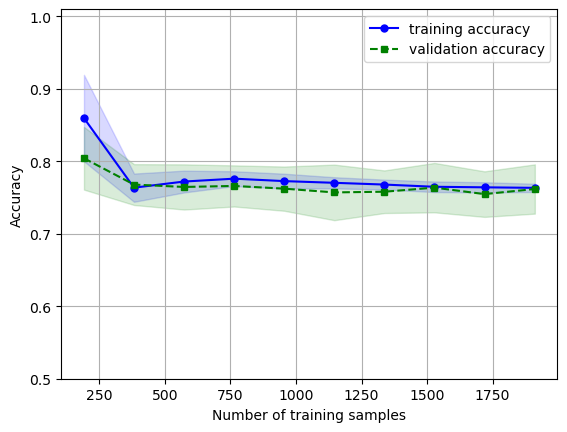


 GNB - Learning Curve


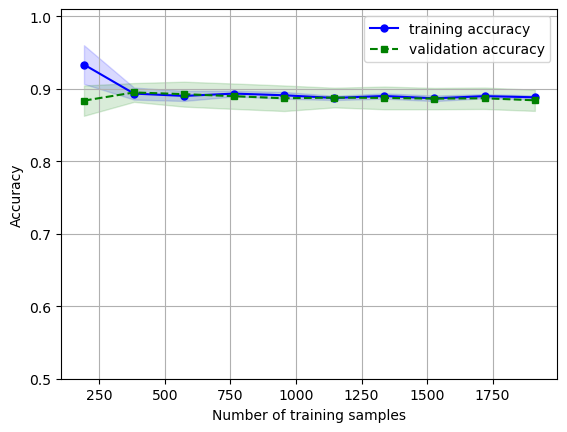

In [31]:
print('Logisistic Regression - Learning Curve')
plot_learning_curves(pipe_logreg)

print('\n GNB - Learning Curve')
plot_learning_curves(pipe_gnb)

In [32]:
#Define Gridsearch Function

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, cv=cv2,scoring='recall_weighted')
    gs_clf = gs_clf.fit(x_train_mod, y_train_mod)
    model = gs_clf.best_estimator_
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test2)
    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Heading
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
    
    #Output Validation Statistics
    print('\nBest Parameters:',bestpara)
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred))   
    
    #Transform the variables into binary (0,1) - ROC Curve
    from sklearn import preprocessing
    Forecast1=pd.DataFrame(y_pred)
    Outcome1=pd.DataFrame(y_test)
    lb1 = preprocessing.LabelBinarizer()
    OutcomeB1 =lb1.fit_transform(Outcome1)
    ForecastB1 = lb1.fit_transform(Forecast1)
    
    #Setup the ROC Curve
    from sklearn.metrics import roc_curve, auc
    from sklearn import metrics
    fpr, tpr, threshold = metrics.roc_curve(OutcomeB1, ForecastB1)
    roc_auc = metrics.auc(fpr, tpr)
    print('ROC Curve')
    #Plot the ROC Curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()   


Optimized Model

Model Name: LogisticRegression(class_weight='balanced', max_iter=1000, random_state=100)

Best Parameters: {'clf__C': 0.01, 'clf__penalty': 'l2'}

 [[535  35]
 [ 75  22]]

               precision    recall  f1-score   support

           0       0.88      0.94      0.91       570
           1       0.39      0.23      0.29        97

    accuracy                           0.84       667
   macro avg       0.63      0.58      0.60       667
weighted avg       0.81      0.84      0.82       667

ROC Curve


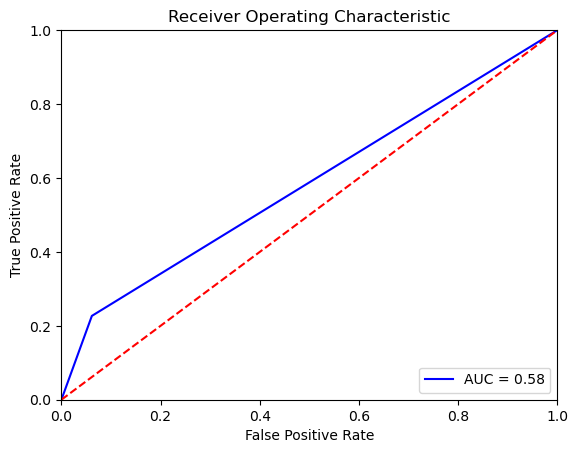


Optimized Model

Model Name: GaussianNB()

Best Parameters: {}

 [[185 385]
 [  9  88]]

               precision    recall  f1-score   support

           0       0.95      0.32      0.48       570
           1       0.19      0.91      0.31        97

    accuracy                           0.41       667
   macro avg       0.57      0.62      0.40       667
weighted avg       0.84      0.41      0.46       667

ROC Curve


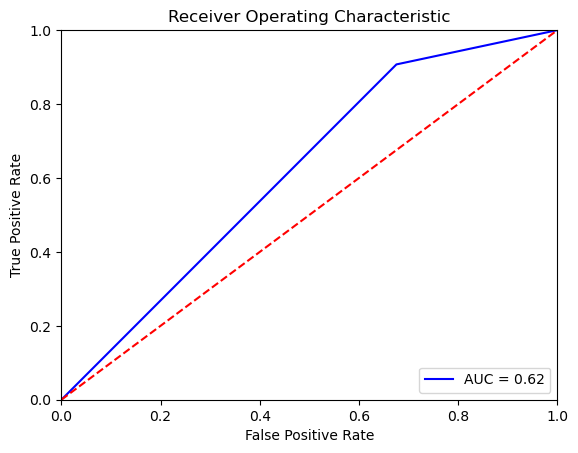

In [33]:
#Run Models

for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)

In [40]:
#Script for Models

from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.ensemble import GradientBoostingClassifier

models2 ={'Logistic Regression':LogisticRegression(solver='lbfgs',
                                                   class_weight='balanced',random_state=100),
          'GBC':GradientBoostingClassifier(random_state=100)}
for name, model in models2.items():
    model.fit(x_train2, y_train_mod)
    predict = model.predict(x_test2)
    print('\nEstimator: {}'.format(name)) 
    print('\n',confusion_matrix(y_test,predict))  
    print(classification_report(y_test,predict)) 


Estimator: Logistic Regression

 [[433 137]
 [ 26  71]]
              precision    recall  f1-score   support

           0       0.94      0.76      0.84       570
           1       0.34      0.73      0.47        97

    accuracy                           0.76       667
   macro avg       0.64      0.75      0.65       667
weighted avg       0.86      0.76      0.79       667


Estimator: GBC

 [[558  12]
 [ 52  45]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       570
           1       0.79      0.46      0.58        97

    accuracy                           0.90       667
   macro avg       0.85      0.72      0.77       667
weighted avg       0.90      0.90      0.89       667



In [39]:
#Create Voting Model - Sklearn
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate

estimators = []

model1 = LogisticRegression(solver='lbfgs',class_weight='balanced',
                            random_state=100)
estimators.append(('Logistic', model1))

model2 = GradientBoostingClassifier(n_estimators=100,random_state=100)
estimators.append(('Gradient Boosting', model2))

voting_clf=VotingClassifier(estimators,voting='soft')

scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro'}
print('\nVoting Model')
for clf in (model1,model2,voting_clf):
    rkfcv= clf.fit(x_train2,y_train_mod)
    ens_rkf1 = RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    rKFcv = cross_validate(rkfcv, x_2, Y, scoring=scoring, cv=ens_rkf1)
    print(clf.__class__.__name__,round(rKFcv['test_rec_macro'].mean(),2))   


Voting Model
LogisticRegression 0.76
GradientBoostingClassifier 0.82
VotingClassifier 0.84
